In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import pickle as pkl
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.gaussian_process.kernels import DotProduct, RBF, RationalQuadratic

In [2]:
def load_data_from_pfile(file_path):  # helper function
    with open(file_path, 'rb') as pfile:
        sample_data = pkl.load(pfile)
    return sample_data

In [4]:
class PHMTestDataset_Sequential(Dataset):
    def __init__(self, dataset='', seq_len=5):
        self.data = load_data_from_pfile(dataset)
        self.seq_len = seq_len
    
    def __len__(self):
        return self.data['x'].shape[0]-self.seq_len+1
    
    def __getitem__(self, i):
        sample = {'x': torch.from_numpy(self.data['x'][i:i+self.seq_len])}
        return sample

#테스트 데이터에 대한 pkl파일 경로

In [5]:
%cd /home/i4624/vscode/gitclone/SWbootProject_2023-7/Team-project

/home/i4624/vscode/gitclone/SWbootProject_2023-7/Team-project


In [6]:
test_pkzfiles_path = '/home/i4624/vscode/gitclone/SWbootProject_2023-7/Team-project/data/ieee-phm-2012-data-challenge-dataset-master/Test_set/'

In [7]:
def conv_bn_relu(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', batch_norm=True):
    conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias, padding_mode=padding_mode)
    nn.init.xavier_uniform_(conv.weight)
    relu = nn.ReLU()
    if batch_norm:
        return nn.Sequential(
            conv,
            nn.BatchNorm2d(out_channels),
            relu
        )
    else:
        return nn.Sequential(
            conv,
            relu
        )

In [8]:
class CNN_CWT_Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_bn_relu(2, 16, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = conv_bn_relu(16, 32, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = conv_bn_relu(32, 64, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv4 = conv_bn_relu(64, 128, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8192, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(p=0.2)

    def forward(self, x):
        # input shape = [Nx2x128x128]
        x = self.conv1(x) # [Nx16x128x128]
        x = self.pool1(x) # [Nx16x64x64]
        x = self.conv2(x) # [Nx32x64x64]
        x = self.pool2(x) # [Nx32x32x32]
        x = self.conv3(x) # [Nx64x32x32]
        x = self.pool3(x) # [Nx64x16x16]
        x = self.conv4(x) # [Nx128x16x16]
        x = self.pool4(x) # [Nx128x8x8]
        x = self.flatten(x) # [Nx8192] {128*8*8=8192} (N => batch size, 128 => no. of channels, 8*8 => height of image*width of image)
        x = self.fc1(x) # [Nx256] 
        # x = self.dropout1(x) # apply dropout (Dropout is much harder to implement in LSTM)
        x = nn.ReLU()(x) # apply ReLU activation
        x = self.fc2(x) # [Nx128]
        x = nn.ReLU()(x) # apply ReLU activation
        return x

In [9]:
class CNN_LSTM_FP(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CNN_CWT_Encoder()
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=256, num_layers=2, batch_first=True)
        self.fc = nn.Linear(256, 1)
    
    def forward(self, x):
        # input shape = [N x l x 2 x 128 x 128] Here, N - batch size, l - sequence length (i.e. SEQ_LEN = 5),  2 - no. of channels or no. of filters, 
                                                      # 128 * 128 - height of an image * width of an image
        batch_size, seq_len, C, H, W = x.size()
        x = x.view(batch_size*seq_len, C, H, W) # transform input of shape [N x l x 2 x 128 x 128] into input of shape [(Nxl) x 2 x 128 x 128]. basically,
                                                # converting(= transforming) into sequences. [(Nxl) x 2 x 128 x 128] - transformed input sequence
        x = self.encoder(x) # pass transformed input sequence through CNN Encoder, CNN Encoder converts the image input data sequence of shape 
                            # [(Nxl) x 2 x 128 x 128] into linear vector sequence by flatenning, output feature vector sequence shape = [(Nxl) x 128]
        x = x.view(batch_size, seq_len, -1) # transform encoded feature vector sequence into time distributed(= shared, alloted, assigned) input as required by
                                            # LSTM unit or LSTM cell
        x, _ = self.lstm1(x) # pass transformed encoded feature vector sequence through LSTM unit or LSTM cell, _ variable contains the hidden layers or hidden
                             # states of LSTM, we don't require those hidden layers in our implementation, therefore just stored in _ variable, and if we want
                             # we can initialize(= activate, start) hidden states from _ variable, here hidden states are the array of zeroes
        x = self.fc(x[:,-1,:]) # pass last vector sequence(i.e. output vector sequence of LSTM unit at last time step) through fully connected network layer
        x = nn.Sigmoid()(x)
        return x    

In [10]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Declaring a variable "device" which will hold the device(i.e. either GPU or CPU) we are 
                                                                      #training the model on
print(device)
device

cpu


device(type='cpu')

In [11]:
model = CNN_LSTM_FP().to(device)

#Testing

In [12]:
model.load_state_dict(torch.load('/home/i4624/vscode/gitclone/SWbootProject_2023-7/Team-project/model/CNN-LSTM/inout/cnn_lstm_model3.pth'))

<All keys matched successfully>

In [50]:
## make_csv file of result
import csv
def make_csv(filename,X_test,y_test):
    # Save the figure to a CSV file
    with open(filename+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['x', 'y'])
        for i in range(len(X_test)):
            writer.writerow([X_test[i], y_test[i]])

In [13]:
def model_inference_helper(model, dataloader):
    results = {'predictions':[]}
    model.eval()
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float)

        with torch.no_grad():
            y_prediction = model(x)

        if y_prediction.size(0)>1:
            results['predictions'] += y_prediction.cpu().squeeze().tolist()
        elif y_prediction.size(0)==1:
            results['predictions'].append(y_prediction.cpu().squeeze().tolist())
    return results

#Bearing1_3

/home/i4624/vscode/gitclone/SWbootProject_2023-7/Team-project/data/ieee-phm-2012-data-challenge-dataset-master/Test_set/bearing1_3_test_data.pkz


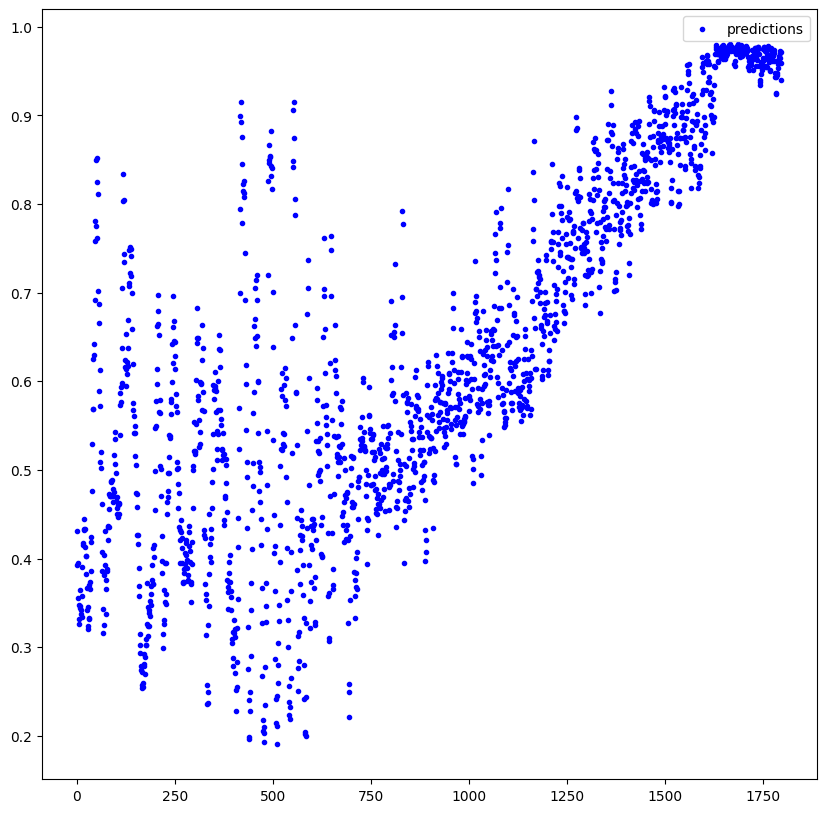

In [14]:
test_pfile = '/home/i4624/vscode/gitclone/SWbootProject_2023-7/Team-project/data/ieee-phm-2012-data-challenge-dataset-master/Test_set/bearing1_3_test_data.pkz'
print(test_pfile)
test_dataset = PHMTestDataset_Sequential(dataset=test_pfile)

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=1)

results = model_inference_helper(model, test_dataloader)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.legend()
plt.show()

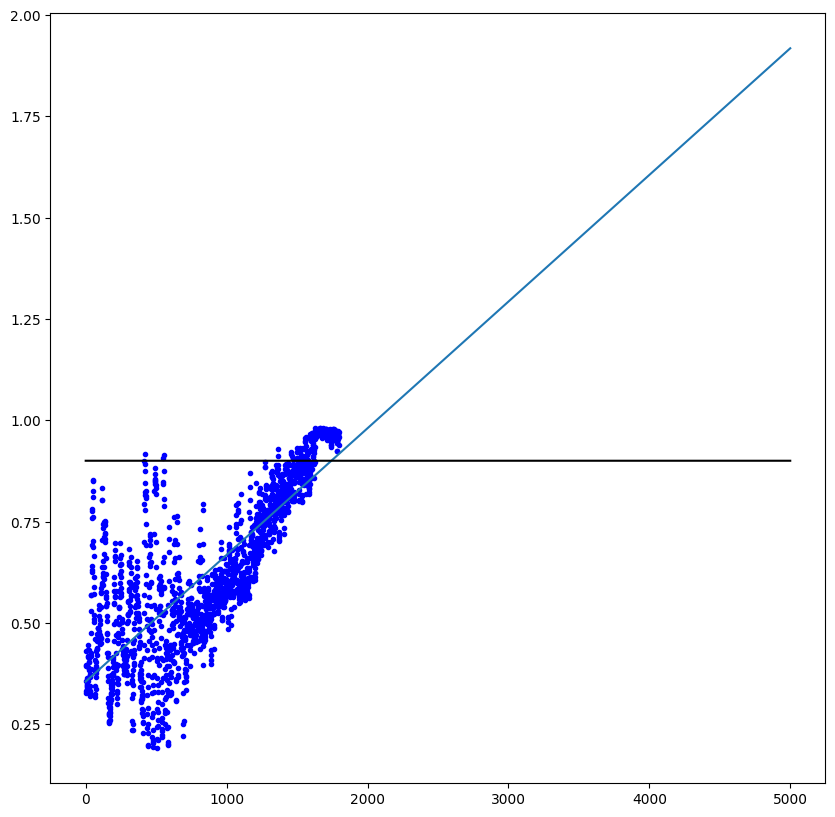

In [15]:

# Create the data
X = np.arange(len(results['predictions'])).reshape(-1, 1)
y = np.array(results['predictions']).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

# Create the test data
X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = reg.predict(X_test)

# Create the figure and axes
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])

# Plot the data
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test)
ax.plot(X_test, [0.9]*len(X_test), 'k')



plt.show()

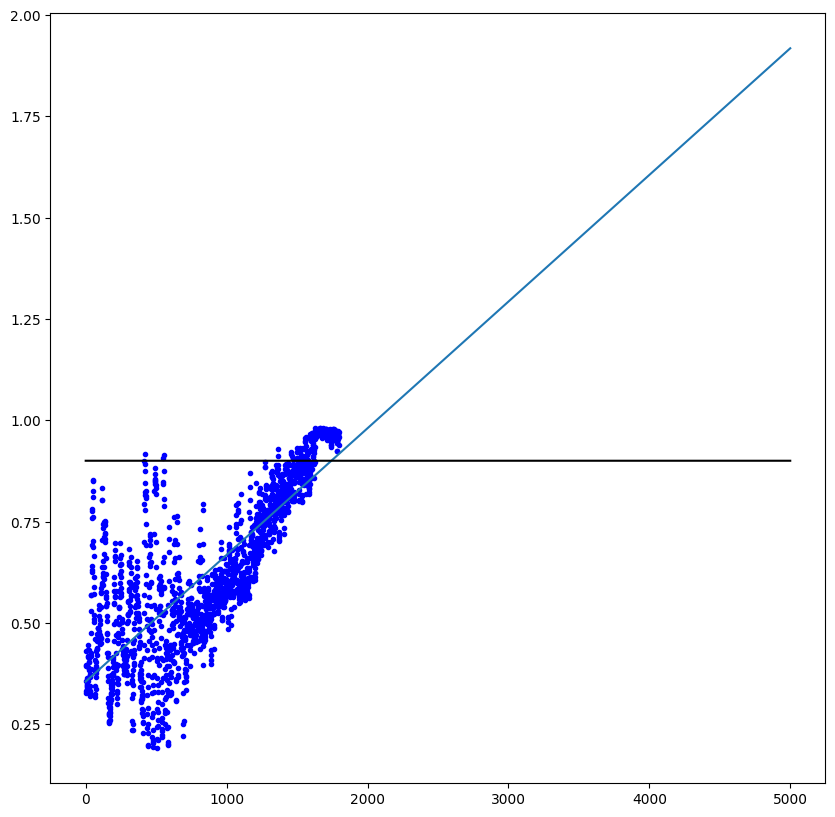

In [16]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = reg.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test)
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

In [17]:
print(y_test)

[0.4316006  0.47964802 0.39258343 ... 0.83602375 0.83597827 0.8359328 ]


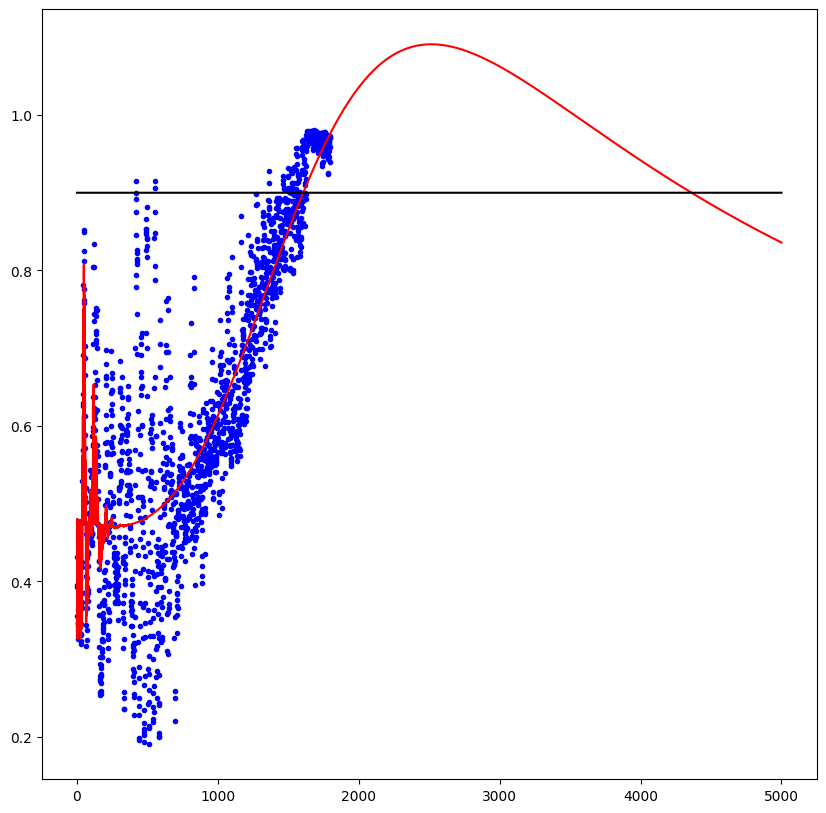

In [17]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
gp_kernel = RBF(0.01)+RationalQuadratic(0.1)

gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = gpr.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test, 'r')
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

#Bearing1_4

In [60]:
filename = os.path.basename(test_pfile)
filename

'bearing1_4_test_data.pkz'

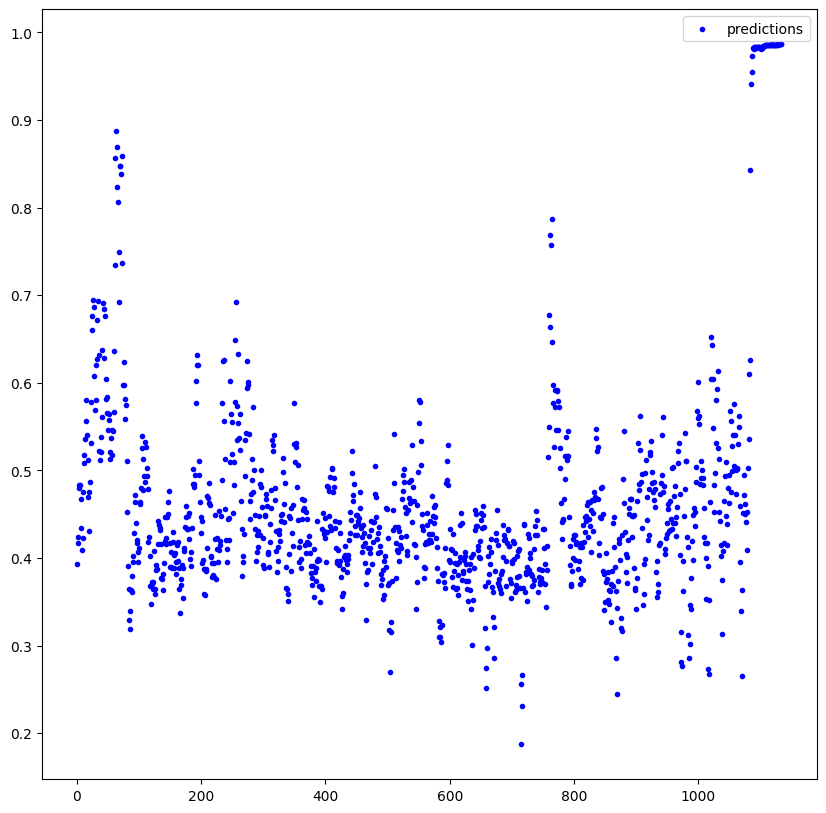

In [48]:
test_pfile = test_pkzfiles_path+'bearing1_4_test_data.pkz'
test_dataset = PHMTestDataset_Sequential(dataset=test_pfile)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=1)

results = model_inference_helper(model, test_dataloader)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.legend()
plt.show()

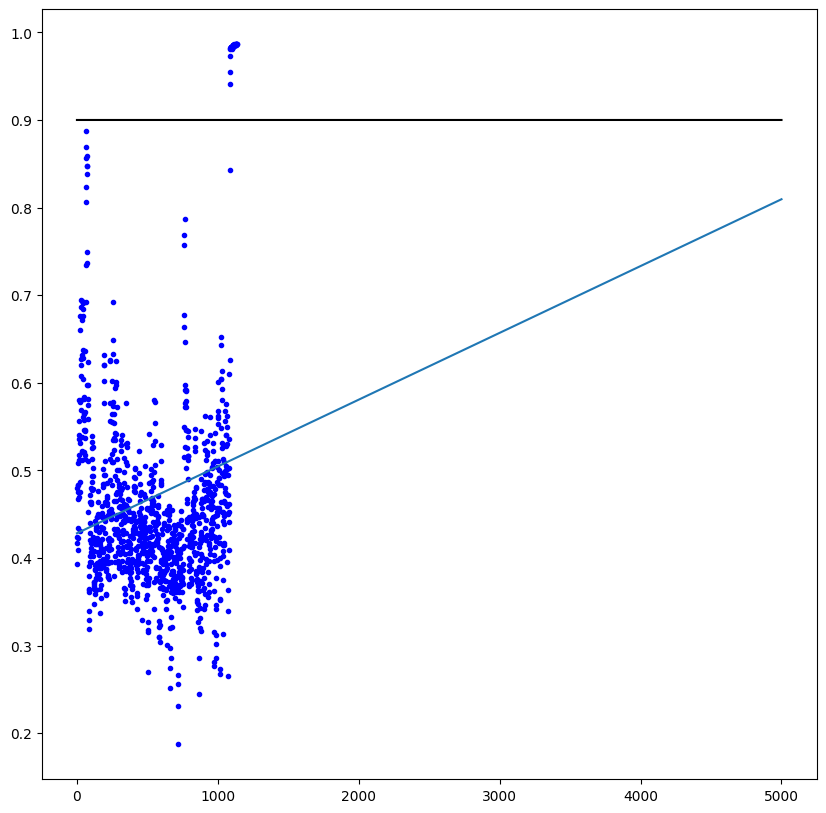

In [51]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = reg.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test)
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

TypeError: expected str, bytes or os.PathLike object, not ConcatDataset

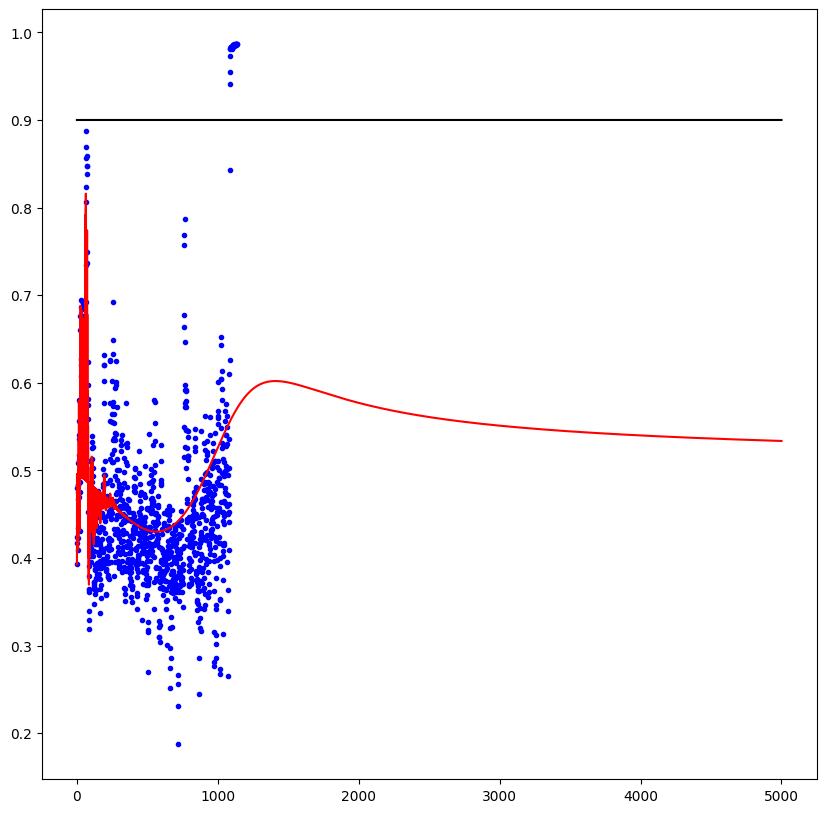

In [53]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
gp_kernel = RBF(0.01)+RationalQuadratic(0.1)

gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = gpr.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test, 'r')
ax.plot(X_test, [0.9]*len(X_test), 'k')

plt.show()

In [61]:
filename = os.path.basename(test_pfile)
make_csv(filename,X_test,y_test)

#Bearing1_5

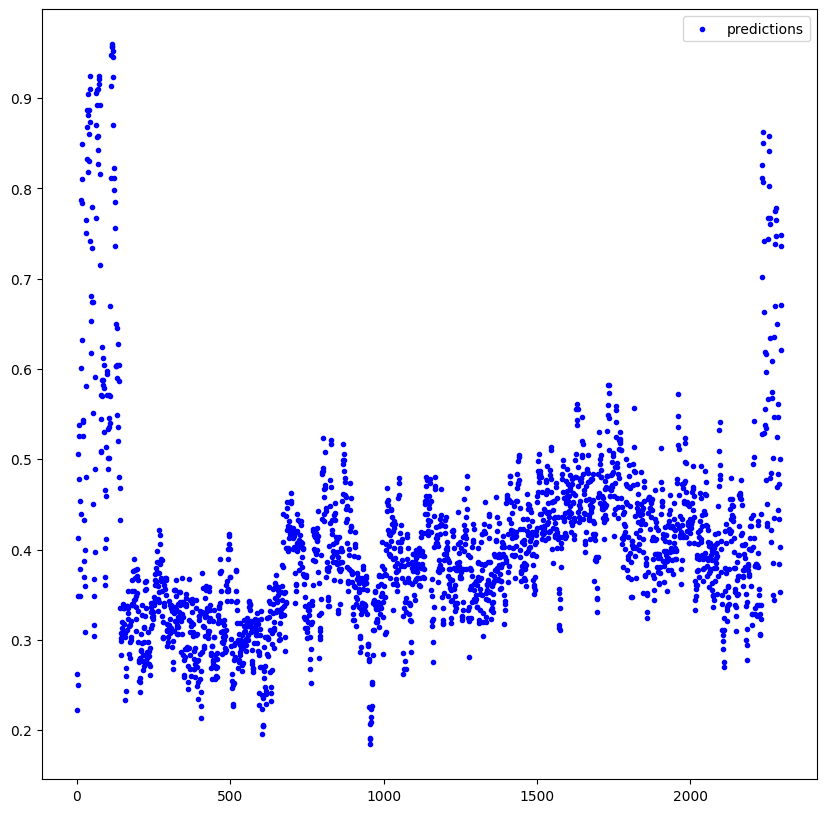

In [21]:
test_pfile = test_pkzfiles_path+'bearing1_5_test_data.pkz'
test_dataset = PHMTestDataset_Sequential(dataset=test_pfile)

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=1)

results = model_inference_helper(model, test_dataloader)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.legend()
plt.show()

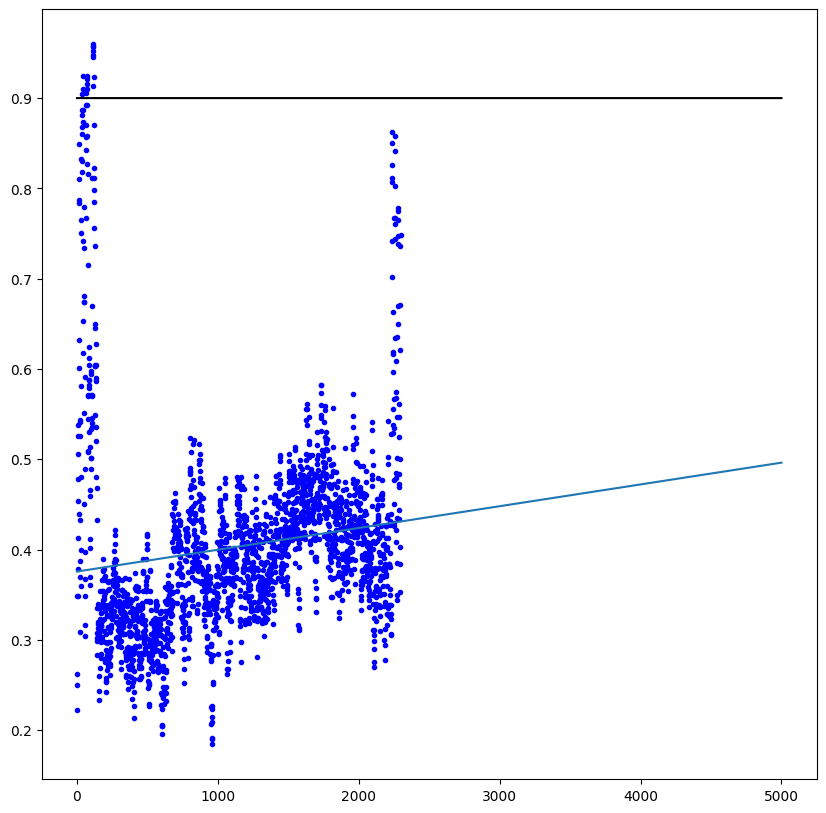

In [22]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = reg.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test)
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

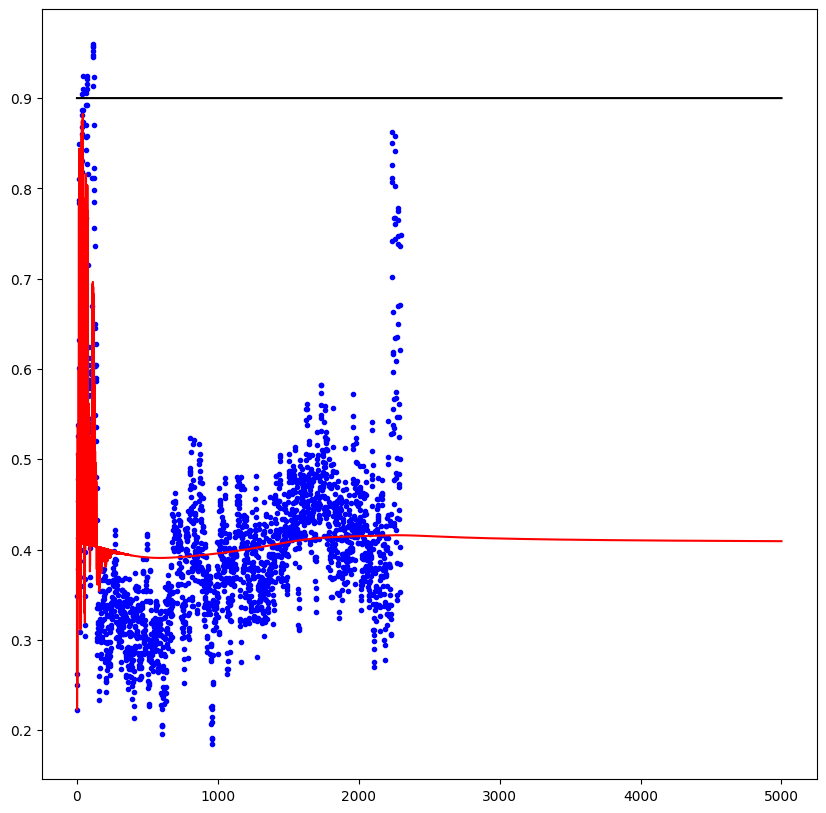

In [23]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
gp_kernel = RBF(0.01)+RationalQuadratic(0.1)

gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = gpr.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test, 'r')
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

#Bearing1_6

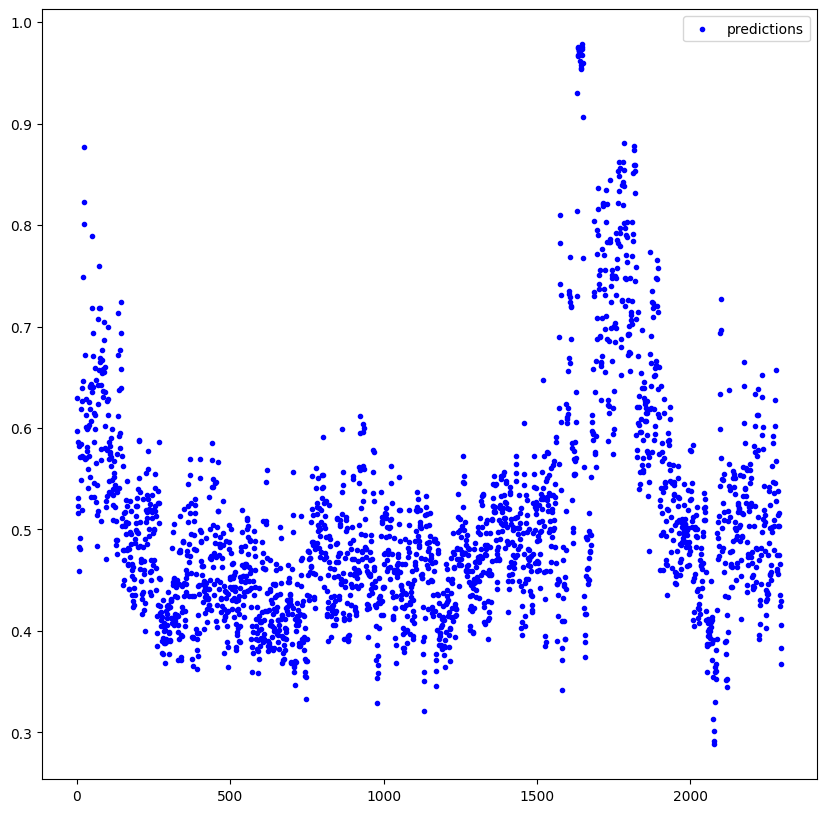

In [62]:
test_pfile = test_pkzfiles_path+'bearing1_6_test_data.pkz'
test_dataset = PHMTestDataset_Sequential(dataset=test_pfile)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=1)

results = model_inference_helper(model, test_dataloader)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.legend()
plt.show()

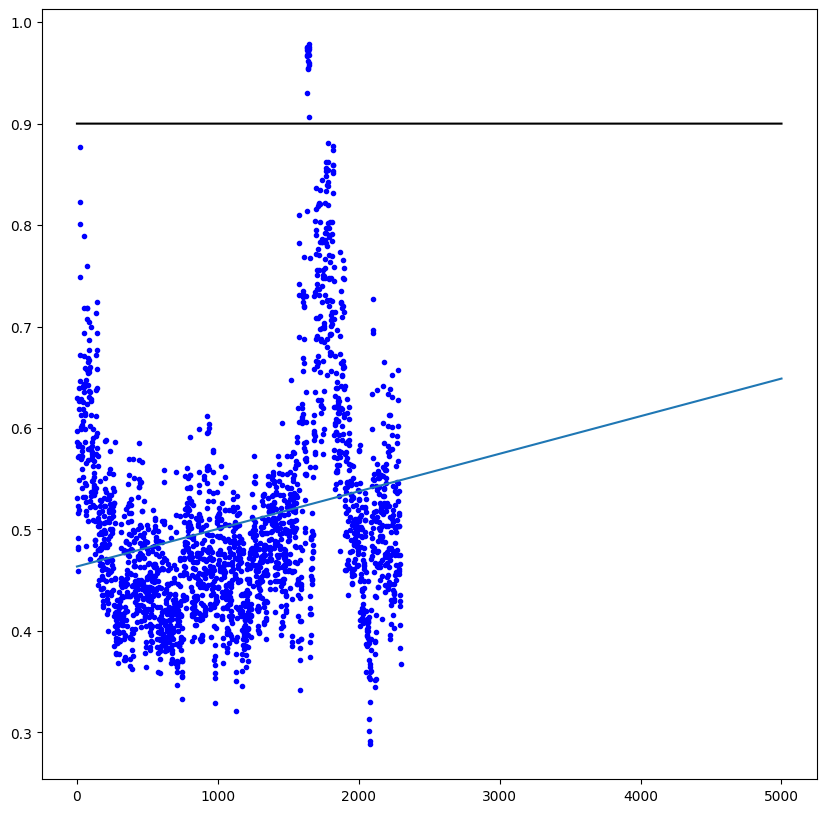

In [63]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = reg.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test)
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

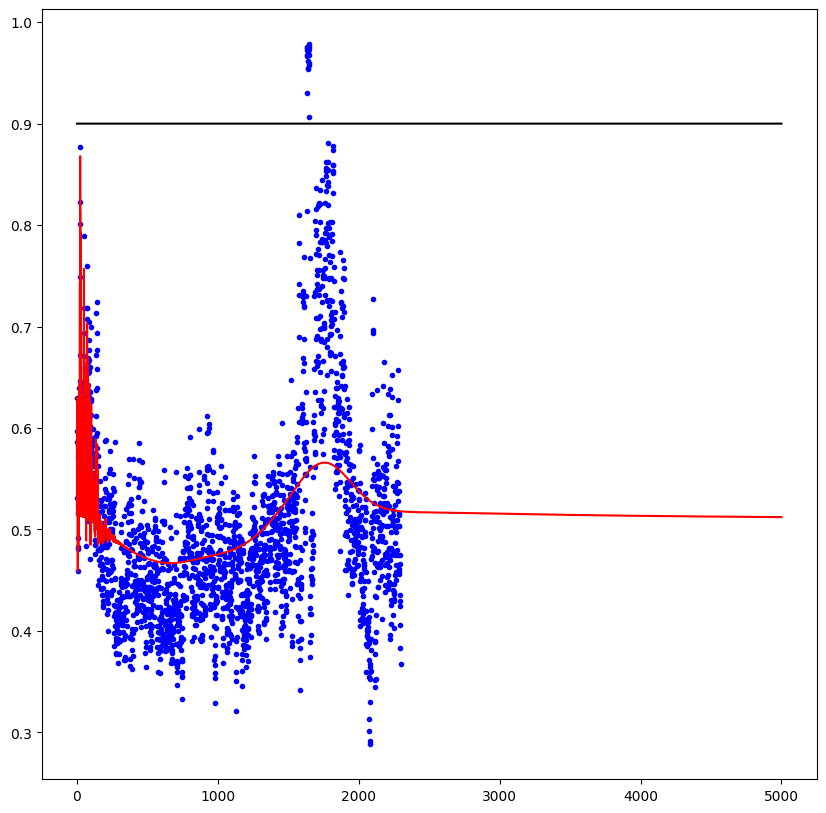

In [26]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
gp_kernel = RBF(0.01)+RationalQuadratic(0.1)

gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = gpr.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test, 'r')
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

#Bearing1_7

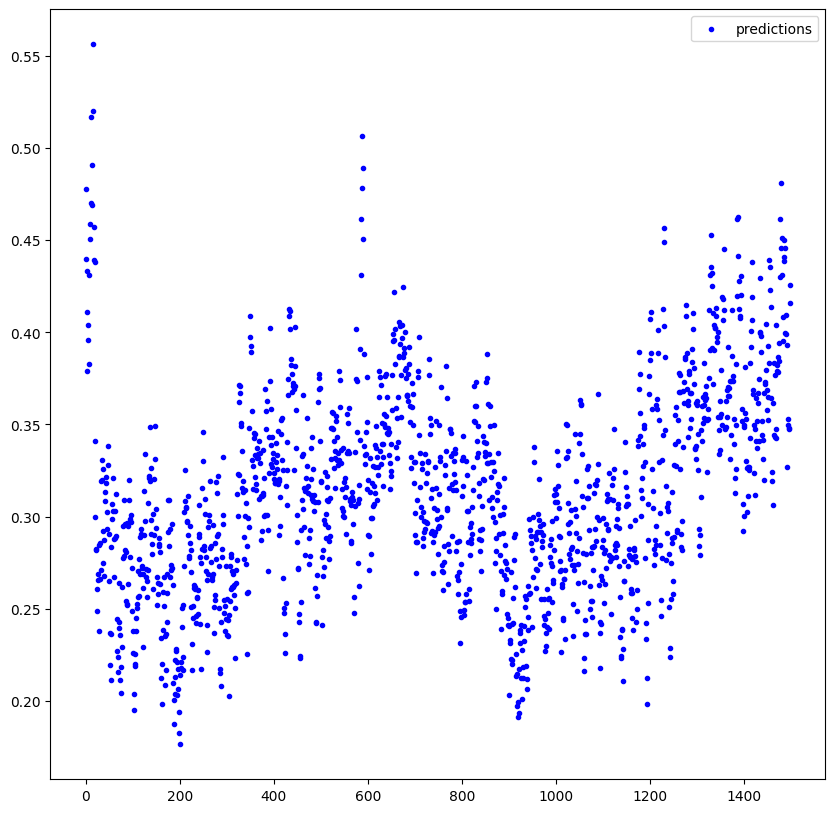

In [64]:
test_pfile = test_pkzfiles_path+'bearing1_7_test_data.pkz'
test_dataset = PHMTestDataset_Sequential(dataset=test_pfile)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=1)

results = model_inference_helper(model, test_dataloader)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.legend()
plt.show()

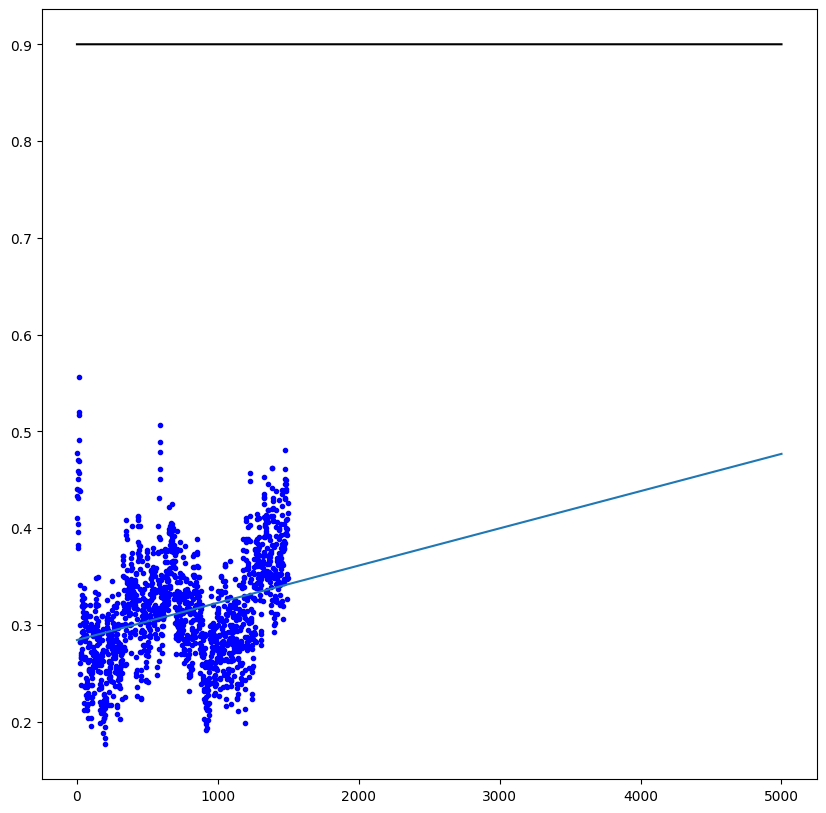

In [65]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = reg.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test)
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

/home/i4624/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/i4624/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


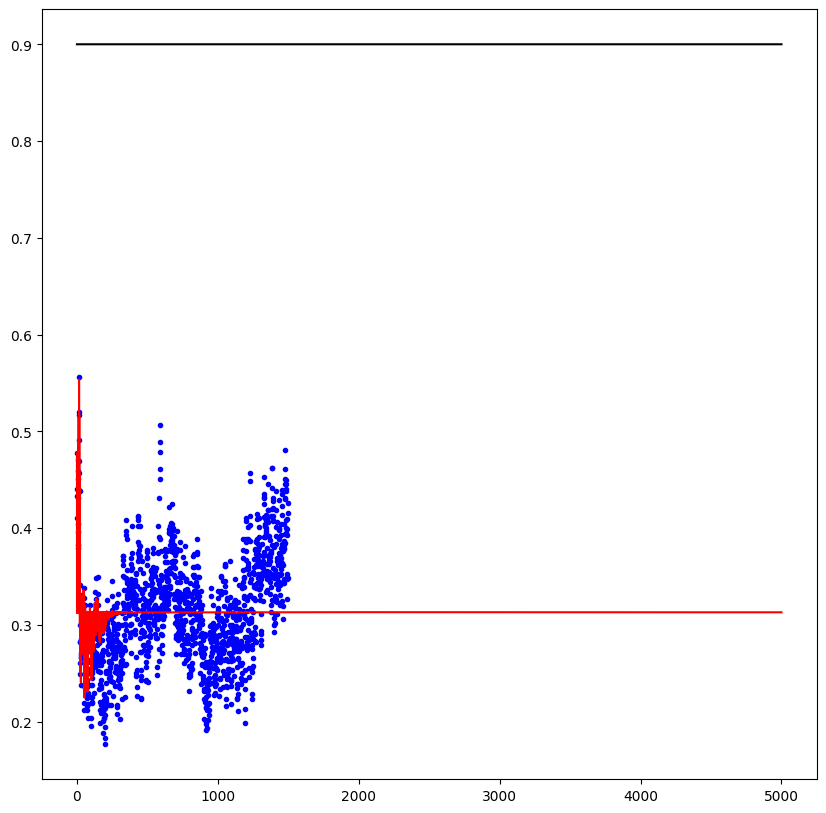

In [29]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
gp_kernel = RBF(0.01)+RationalQuadratic(0.1)

gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = gpr.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test, 'r')
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

#Bearing2_3

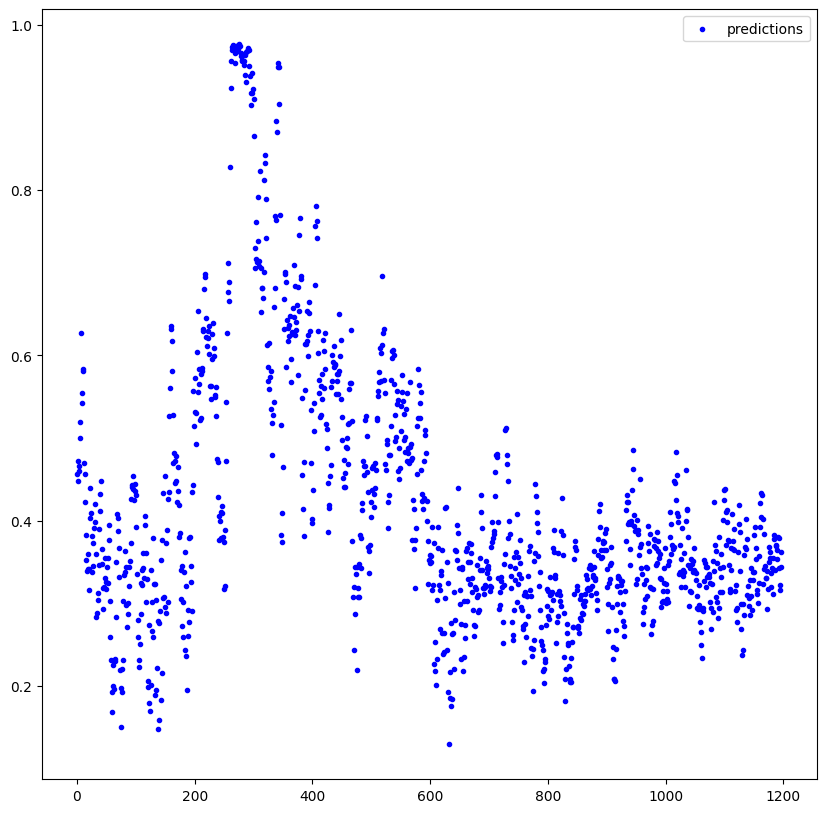

In [30]:
test_pfile = test_pkzfiles_path+'bearing2_3_test_data.pkz'
test_dataset = PHMTestDataset_Sequential(dataset=test_pfile)

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=1)

results = model_inference_helper(model, test_dataloader)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.legend()
plt.show()

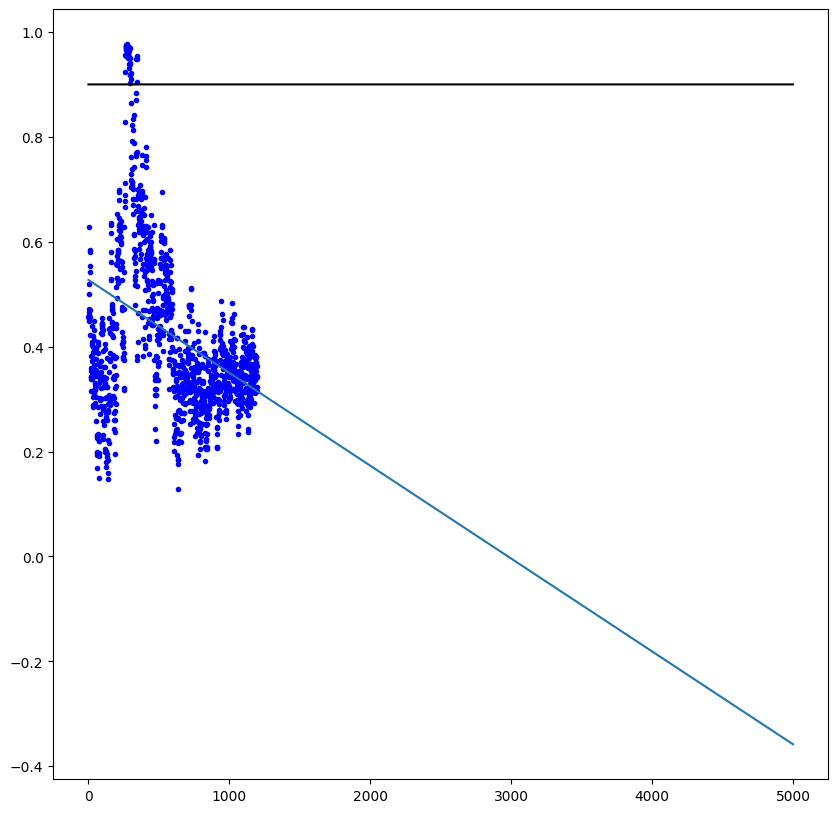

In [31]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = reg.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test)
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

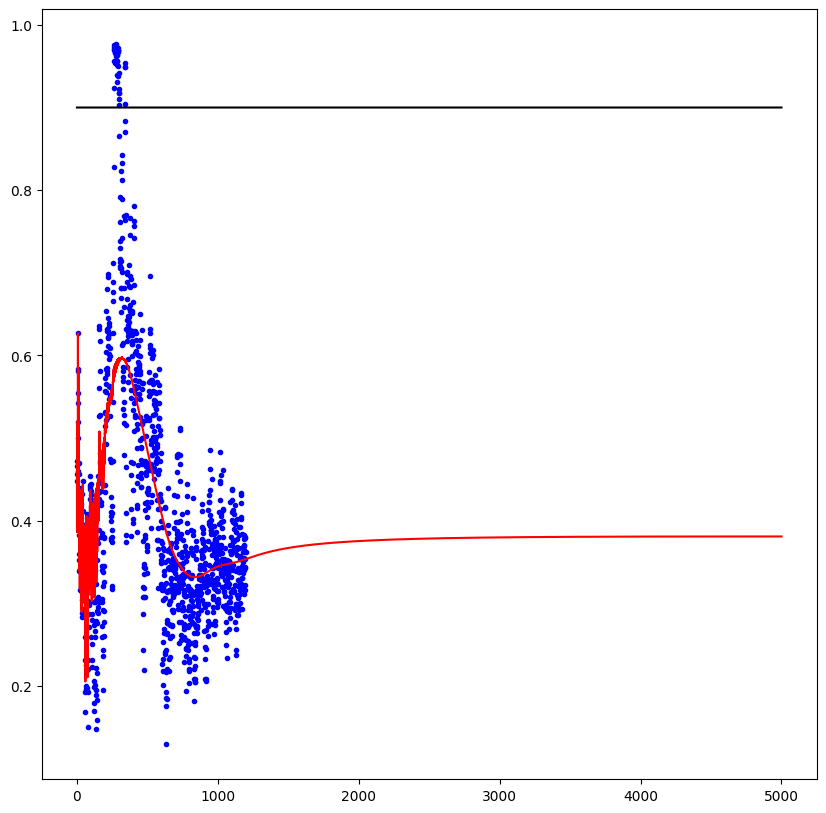

In [32]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
gp_kernel = RBF(0.01)+RationalQuadratic(0.1)

gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = gpr.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test, 'r')
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

#Bearing2_4


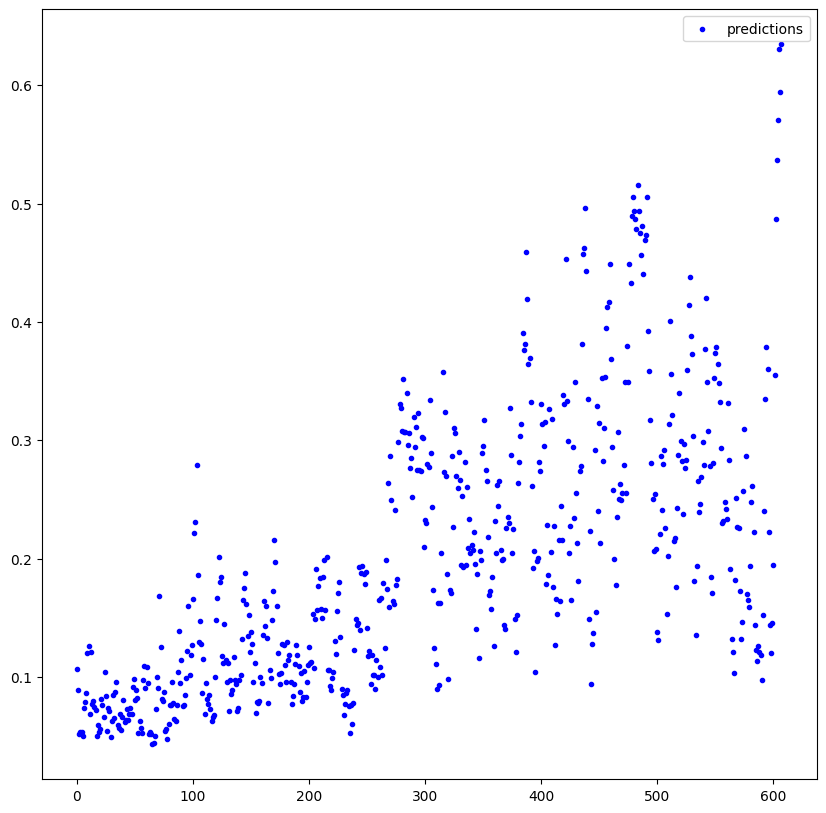

In [33]:
test_pfile = test_pkzfiles_path+'bearing2_4_test_data.pkz'
test_dataset = PHMTestDataset_Sequential(dataset=test_pfile)

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=1)

results = model_inference_helper(model, test_dataloader)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.legend()
plt.show()

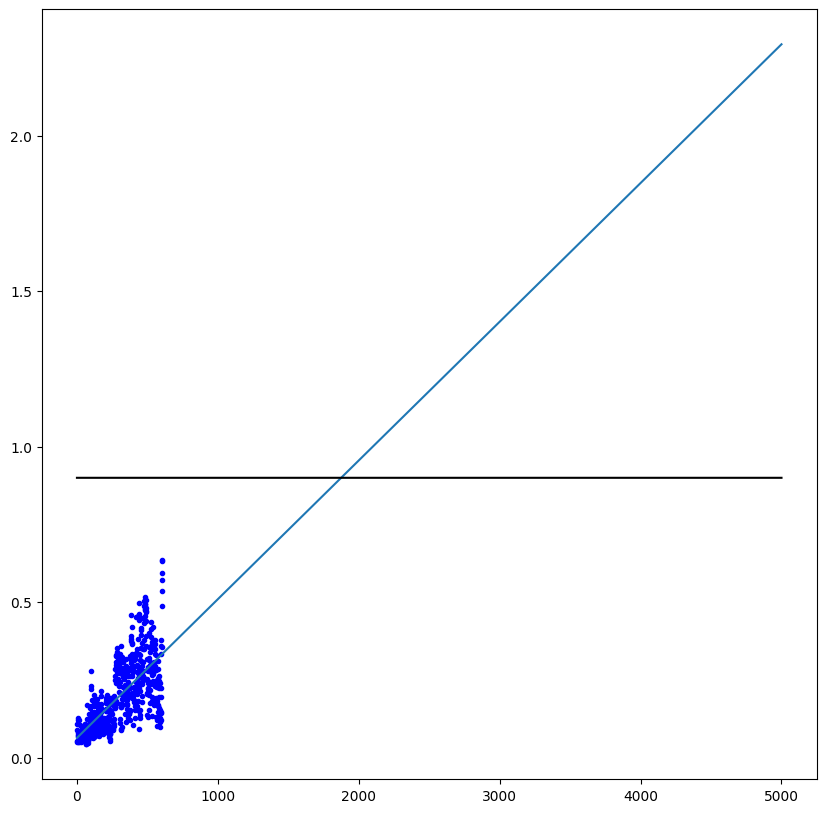

In [34]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = reg.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test)
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

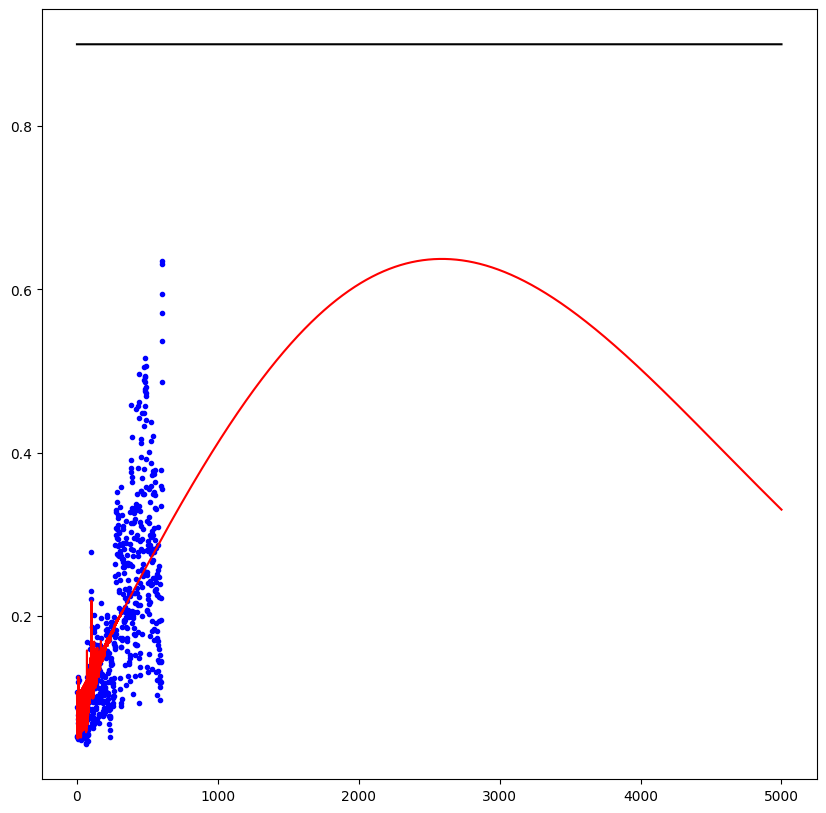

In [35]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
gp_kernel = RBF(0.01)+RationalQuadratic(0.1)

gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = gpr.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test, 'r')
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

#Bearing2_5

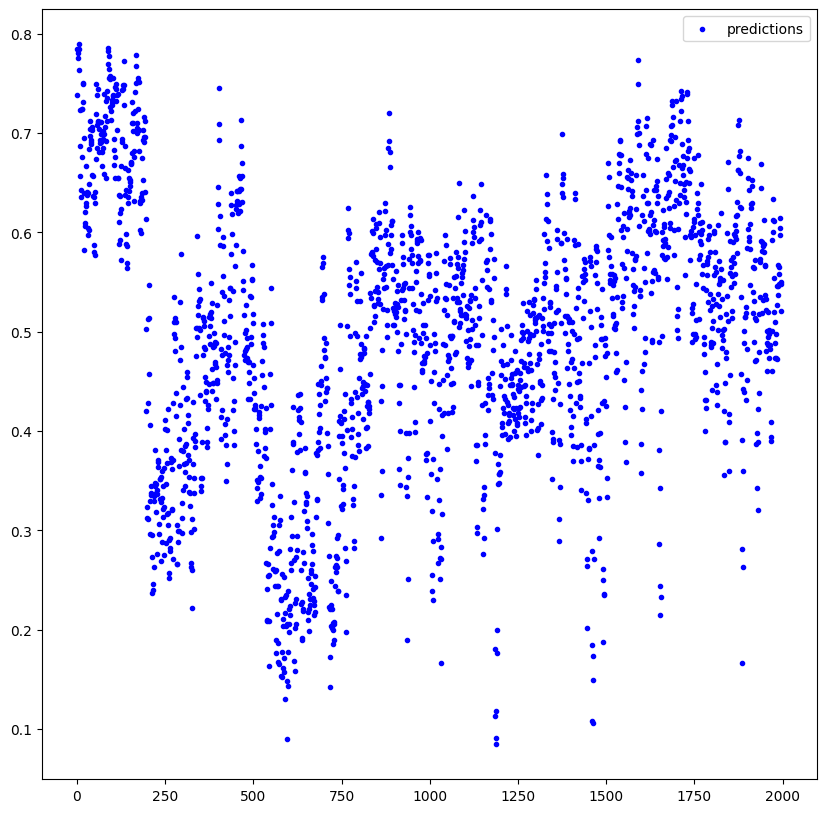

In [36]:
test_pfile = test_pkzfiles_path+'bearing2_5_test_data.pkz'
test_dataset = PHMTestDataset_Sequential(dataset=test_pfile)

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=1)

results = model_inference_helper(model, test_dataloader)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.legend()
plt.show()

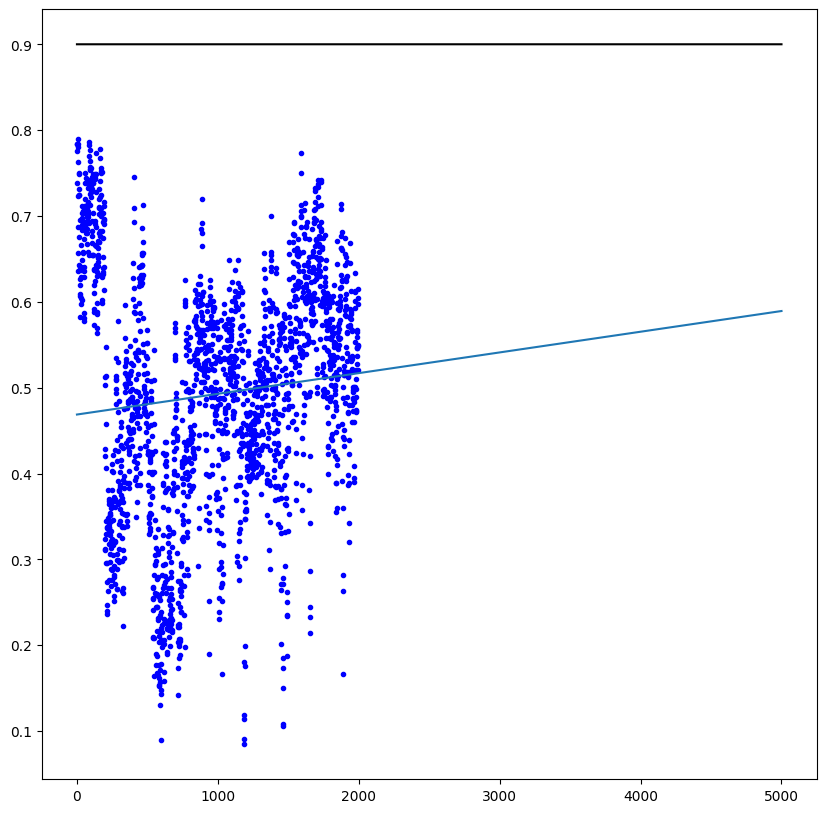

In [37]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = reg.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test)
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

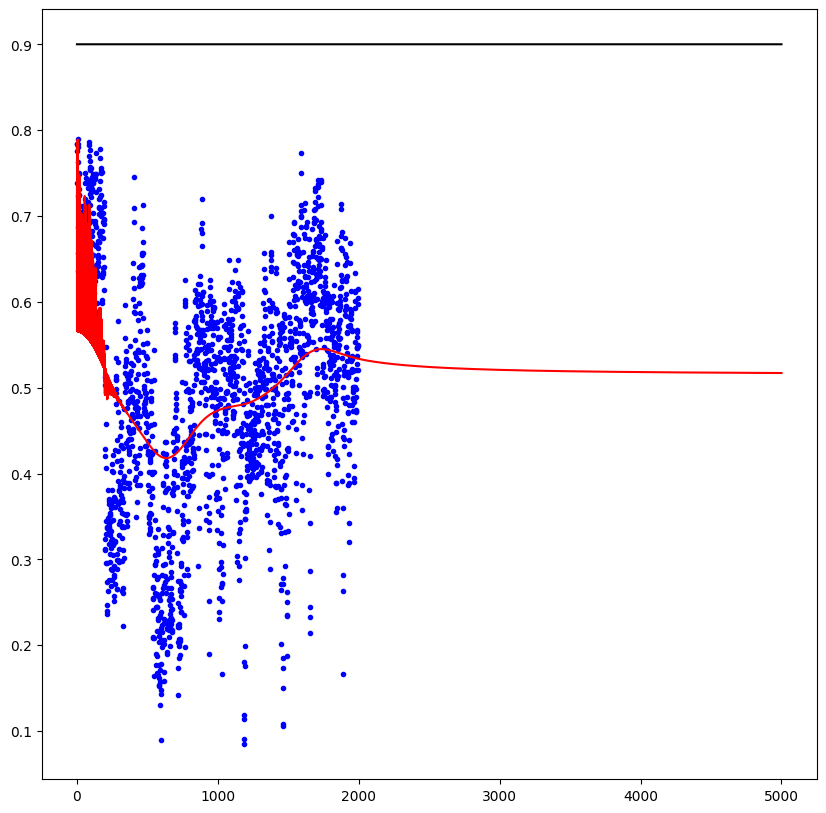

In [38]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
gp_kernel = RBF(0.01)+RationalQuadratic(0.1)

gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = gpr.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test, 'r')
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

#Bearing2_6

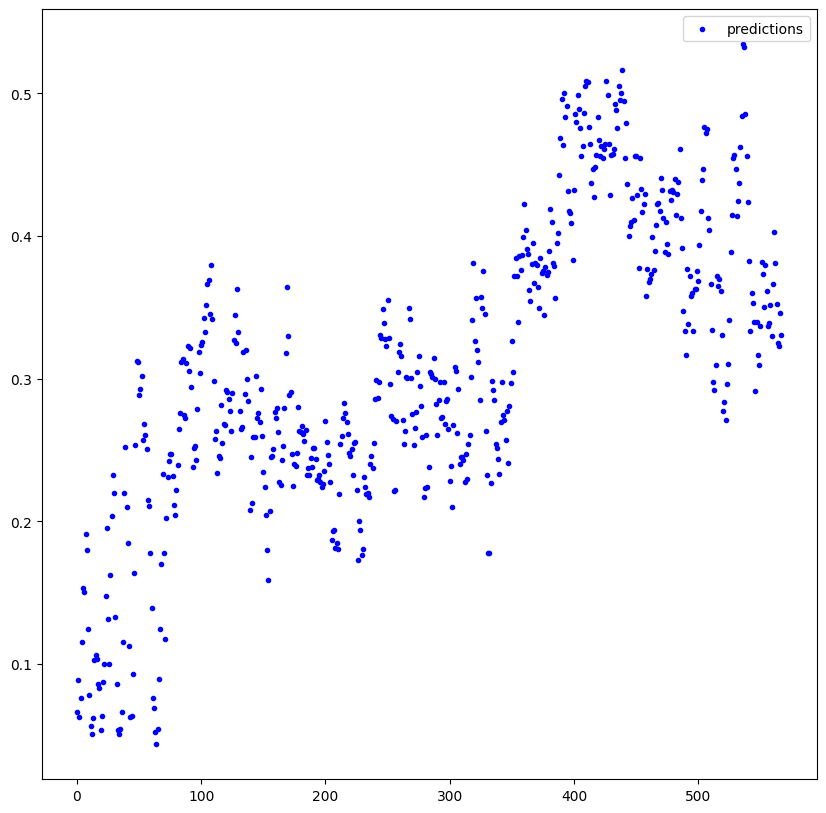

In [39]:
test_pfile = test_pkzfiles_path+'bearing2_6_test_data.pkz'
test_dataset = PHMTestDataset_Sequential(dataset=test_pfile)

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=1)

results = model_inference_helper(model, test_dataloader)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.legend()
plt.show()

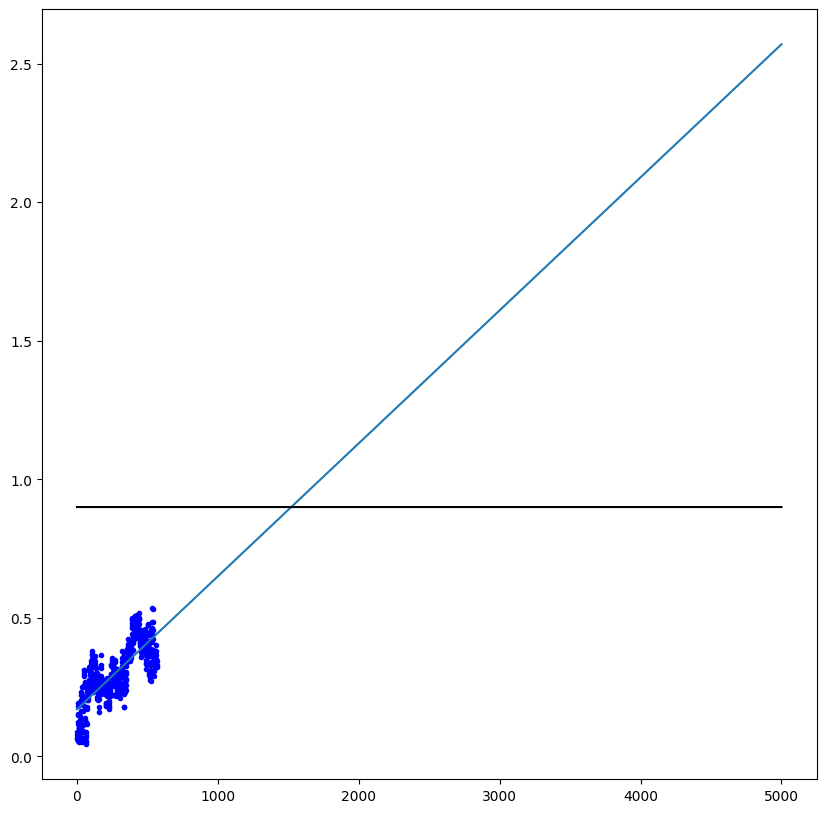

In [40]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = reg.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test)
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

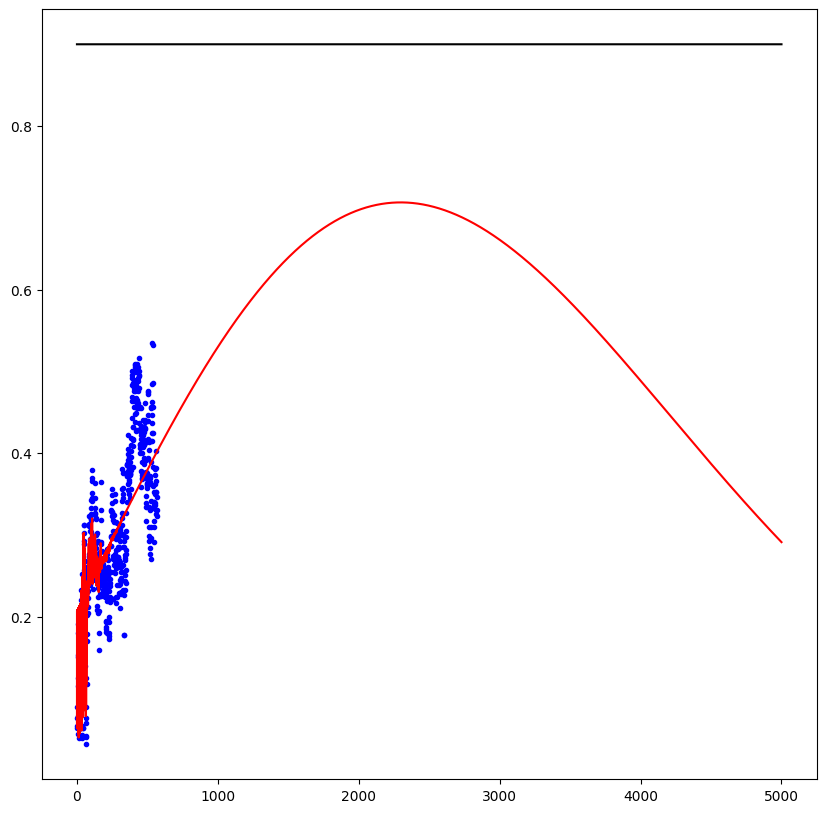

In [41]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
gp_kernel = RBF(0.01)+RationalQuadratic(0.1)

gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = gpr.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test, 'r')
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

#Bearing2_7



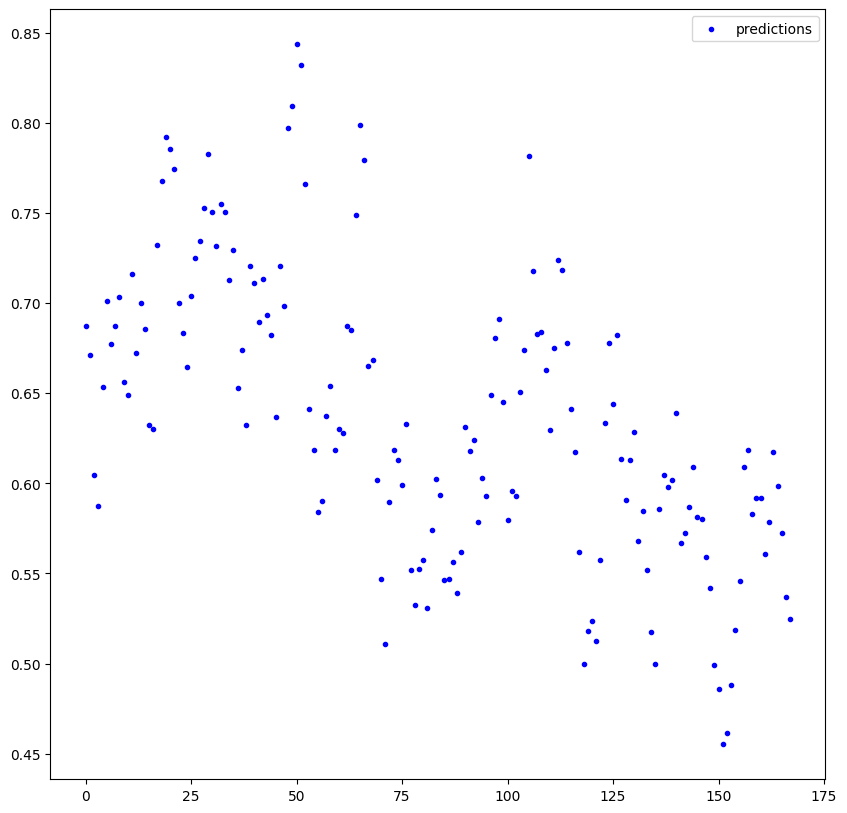

In [42]:
test_pfile = test_pkzfiles_path+'bearing2_7_test_data.pkz'
test_dataset = PHMTestDataset_Sequential(dataset=test_pfile)

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=1)

results = model_inference_helper(model, test_dataloader)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.legend()
plt.show()

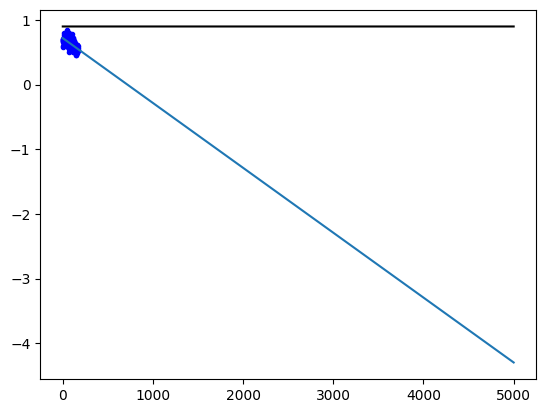

In [43]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = reg.predict(X_test)
plt.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
plt.plot(X_test, y_test)
plt.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

/home/i4624/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/i4624/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


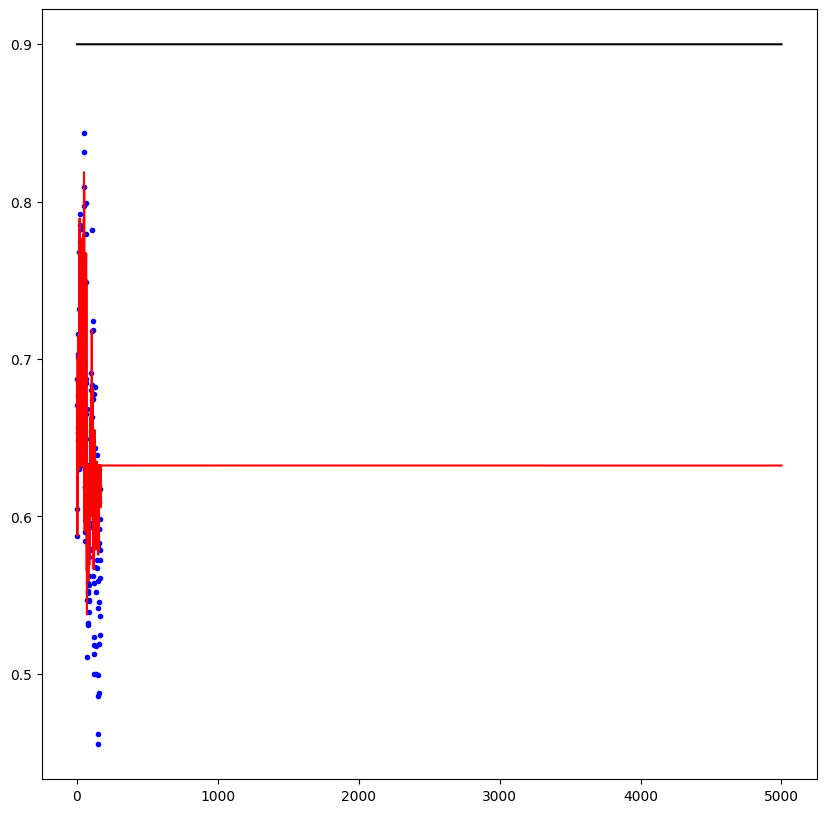

In [44]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
gp_kernel = RBF(0.01)+RationalQuadratic(0.1)

gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = gpr.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test, 'r')
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

#Bearing3_3

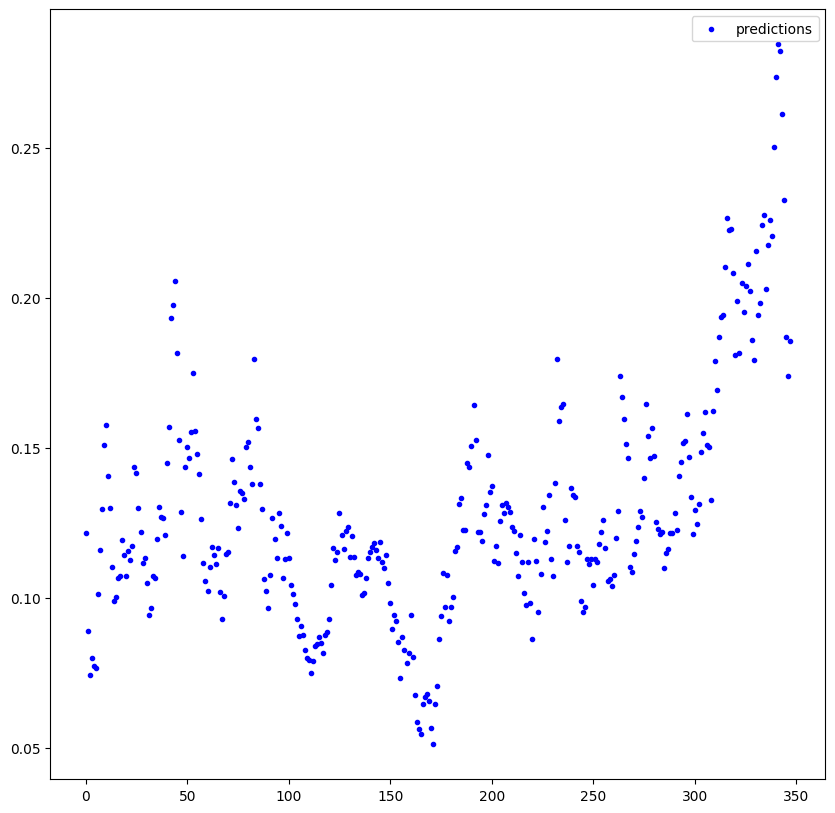

In [45]:
test_pfile = test_pkzfiles_path+'bearing3_3_test_data.pkz'
test_dataset = PHMTestDataset_Sequential(dataset=test_pfile)

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=1)

results = model_inference_helper(model, test_dataloader)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.legend()
plt.show()

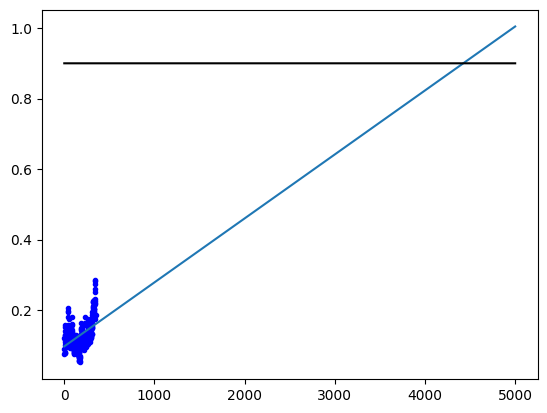

In [46]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = reg.predict(X_test)
plt.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
plt.plot(X_test, y_test)
plt.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()

/home/i4624/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/i4624/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


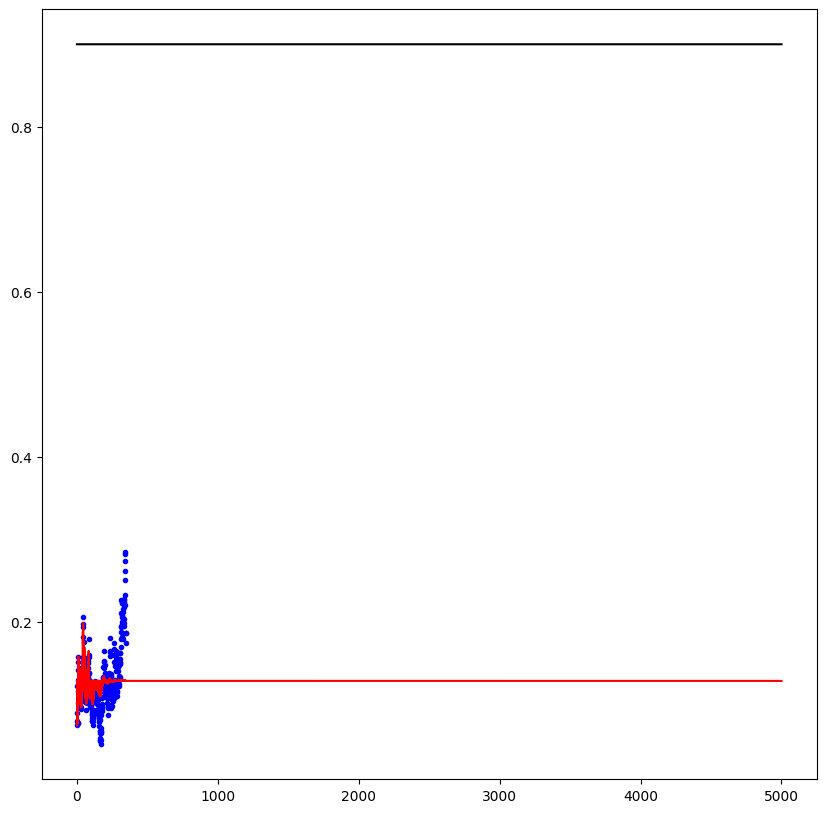

In [47]:
X = np.arange(len(results['predictions'])).reshape(-1,1)
y = np.array(results['predictions']).reshape(-1, 1)
gp_kernel = RBF(0.01)+RationalQuadratic(0.1)

gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

X_test = np.linspace(0, 5000, 10000).reshape(-1, 1)
y_test = gpr.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])
ax.scatter(range(len(results['predictions'])), results['predictions'], c='b', marker='.', label='predictions')
ax.plot(X_test, y_test, 'r')
ax.plot(X_test, [0.9]*len(X_test), 'k')
plt.show()